# <center> ICA and Cocktail problem </center>

We will implement three algorithm for Independent Components Analysis to extract source audio files mixed in the files mix[1-9].wav

Send your notebook and the one of the previous lab to reda.dehak at epita.fr before June 21st. Rename your notebook as SurnameNameTP[2-3].ipynb 

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn import preprocessing
from numpy.linalg import eigh,eig,inv,matrix_power
import IPython.display as Ipd
from scipy.stats import moment, kstat
from numpy import linalg as LA

np.random.seed(seed=0)
matplotlib.rcParams['figure.figsize'] = (17.0, 5.0)
matplotlib.rcParams['font.size'] = 15

%matplotlib inline
%load_ext autoreload
%autoreload 2

1- Load the mixed audio files?

In [2]:
datasrc = np.empty([9, 50000], np.float32)
for i in range(9):
    fs, datasrc[i,] = wavfile.read('./source' + str(i+1) + '.wav')

In [3]:
fs

8000

2- Display audio data?

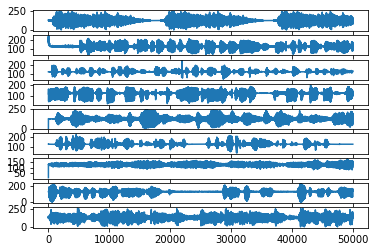

In [4]:
for i in range(9):
    plt.subplot(9, 1, i + 1)
    plt.plot(datasrc[i,])

In [5]:
nb_songs = datasrc.shape[0]
W = np.random.rand(nb_songs,nb_songs)
assert(np.linalg.det(W)!=0)
Mix = W@datasrc
#Assuming the source signals s(t) = [s1(t), s2(t), ... , sN (t)] are mutually independent random variables
print(Mix.shape)
Ipd.Audio(Mix[0,], rate=fs)

(9, 50000)


In [6]:
#M = np.apply_along_axis(lambda mix: mix - mix.mean(), 0, Mix)
def withening(Mix):
    mu_m = Mix.mean(axis=1)
    M = Mix - np.repeat(mu_m, Mix.shape[1]).reshape(Mix.shape)
    assert(M.shape==Mix.shape)
    assert(np.allclose(np.zeros(M.shape[0]),M.mean(axis=1)))

    cov = np.cov(M) #M@M.T
    #assert(np.allclose(cov, M@M.T))
    S, E = eigh(cov)

    #assert(np.allclose(M@M.T, E@np.diag(S)@E.T))

    C = inv(np.diag(S)**0.5)@E.T
    X = C@M #Blanchit
    assert(np.allclose(np.cov(X), np.eye(M.shape[0]))) #Sanity check
    return X,C,M


3- Implement the FOBI algorithm and use it to separate the 9 mixed wav files? 

In [7]:
from numpy.matlib import repmat
def FOBI(Mix):
    X,C,M = withening(Mix)
    norms = np.sum(X*X, axis=0)
    D = (X * repmat(norms.reshape((1,-1)), X.shape[0], 1)) @ X.T
    #D = X @ np.diag(norms) @ X.T
    L, U = eig(D)
    A = U.T@C
    H = A@M
    #check
#     norms = np.sum(H*H, axis=0)
#     D = (H * repmat(norms.reshape((1,-1)), H.shape[0], 1)) @ H.T
#     print(D)
#     assert(np.all(H == np.diag(np.diagonal(H))))
    return H,A

H,A = FOBI(Mix)

4- Compare the error between the original sources and obtained audio files? Listen to the obtained results?

In [18]:
# print(inv(A))
# print(W)
Ipd.Audio(H[8,], rate=fs)

5- Implement the JADE algorithm and use it to separate the 9 mixed wav files? 

In [9]:
#https://arxiv.org/pdf/1706.08171.pdf

#Je n'ai pas pu reprendre l'implementation, Jean-Francois Cardoso initialement en MATLAB ci dessous.

def JADEICA(Mix):
    X,C,M = withening(Mix)
JADEICA(Mix)

6- Compare the error between the original sources and obtained audio files? Listen to the obtained results?

In [10]:
# def jadeR(X, m=None, verbose=True):

#     [n,T] = X.shape # GB: n is number of input signals, T is number of samples
    
#     # Estimation of the cumulant matrices.
#     # ====================================
    
#     # Reshaping of the data, hoping to speed up things a little bit...
#     X = X.T
#     dimsymm = int((m * ( m + 1)) / 2) # Dim. of the space of real symm matrices
#     nbcm = dimsymm  # number of cumulant matrices
    
#     CM = matrix(zeros([m,m*nbcm], dtype=float64)) #Cumulant matrices
#     R = matrix(eye(m, dtype=float64))
#     Qij = matrix(zeros([m,m], dtype=float64)) # Temp for a cum. matrix
#     Xim = zeros(m, dtype=float64) # Temp
#     Xijm = zeros(m, dtype=float64) # Temp
#     #Uns = numpy.ones([1,m], dtype=numpy.uint32)    # for convenience
#     # GB: we don't translate that one because NumPy doesn't need Tony's rule
    
#     # I am using a symmetry trick to save storage.  I should write a short note one of these
#     # days explaining what is going on here.
#     Range = arange(m) # will index the columns of CM where to store the cum. mats.
    
#     for im in range(m):
#         Xim = X[:,im]
#         Xijm = multiply(Xim, Xim)
#         # Note to myself: the -R on next line can be removed: it does not affect
#         # the joint diagonalization criterion
#         Qij = multiply(Xijm, X).T * X / float(T)\
#             - R - 2 * dot(R[:,im], R[:,im].T)
#         CM[:,Range] = Qij 
#         Range = Range  + m 
#         for jm in range(im):
#             Xijm = multiply(Xim, X[:,jm])
#             Qij = sqrt(2) * multiply(Xijm, X).T * X / float(T) \
#                 - R[:,im] * R[:,jm].T - R[:,jm] * R[:,im].T
#             CM[:,Range]	= Qij
#             Range = Range + m

#     # Now we have nbcm = m(m+1)/2 cumulants matrices stored in a big m x m*nbcm array.
   
#     V = matrix(eye(m, dtype=float64))
#     Diag = zeros(m, dtype=float64)
#     On = 0.0
#     Range = arange(m)
#     for im in range(nbcm):
#         Diag = diag(CM[:,Range])
#         On = On + (Diag*Diag).sum(axis=0)
#         Range = Range + m
#     Off = (multiply(CM,CM).sum(axis=0)).sum(axis=0) - On
    
#     seuil = 1.0e-6 / sqrt(T) # % A statistically scaled threshold on `small" angles
#     encore = True
#     sweep = 0 # % sweep number
#     updates = 0 # % Total number of rotations
#     upds = 0 # % Number of rotations in a given seep
#     g = zeros([2,nbcm], dtype=float64)
#     gg = zeros([2,2], dtype=float64)
#     G = zeros([2,2], dtype=float64)
#     c = 0
#     s = 0
#     ton	= 0
#     toff = 0
#     theta = 0
#     Gain = 0
    
#     # Joint diagonalization proper
    
#     while encore:
#         encore = False
#         sweep = sweep + 1
#         upds  = 0
#         Vkeep = V
      
#         for p in range(m-1):
#             for q in range(p+1, m):
                
#                 Ip = arange(p, m*nbcm, m)
#                 Iq = arange(q, m*nbcm, m)
                
#                 # computation of Givens angle
#                 g = concatenate([CM[p,Ip] - CM[q,Iq], CM[p,Iq] + CM[q,Ip]])
#                 gg = dot(g, g.T)
#                 ton = gg[0,0] - gg[1,1] 
#                 toff = gg[0,1] + gg[1,0]
#                 theta = 0.5 * arctan2(toff, ton + sqrt(ton * ton + toff * toff))
#                 Gain = (sqrt(ton * ton + toff * toff) - ton) / 4.0
                
#                 # Givens update
#                 if abs(theta) > seuil:
#                     encore = True
#                     upds = upds + 1
#                     c = cos(theta) 
#                     s = sin(theta)
#                     G = matrix([[c, -s] , [s, c] ])
#                     pair = array([p,q])
#                     V[:,pair] = V[:,pair] * G
#                     CM[pair,:] = G.T * CM[pair,:]
#                     CM[:,concatenate([Ip,Iq])] = \
#                         append( c*CM[:,Ip]+s*CM[:,Iq], -s*CM[:,Ip]+c*CM[:,Iq], \
#                                axis=1)
#                     On = On + Gain
#                     Off = Off - Gain
                    
#         updates = updates + upds
    
#     # A separating matrix
#     # ===================
    
#     B = V.T * B
    
#     # Permute the rows of the separating matrix B to get the most energetic components first.
#     # Here the **signals** are normalized to unit variance.  Therefore, the sort is
#     # according to the norm of the columns of A = pinv(B)

#     A = pinv(B)
#     keys =  array(argsort(multiply(A,A).sum(axis=0)[0]))[0]
#     B = B[keys,:]
#     B = B[::-1,:]     # % Is this smart ?
    
    
#     b = B[:,0]
#     signs = array(sign(sign(b)+0.1).T)[0] # just a trick to deal with sign=0
#     B = diag(signs) * B
#     return B.astype(origtype)

7- Implement the FASTICA algorithm and use it to separate the 9 mixed wav files? 

In [11]:
def fn_and_der(u):
    return 1/4 * np.power(u,4),np.power(u,3)

def calculate_new_w(w, X):
    g, g_der = fn_and_der(np.dot(w.T, X))
    w_new = (X * g).mean(axis=1) - g_der.mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

# peu concluant
# def calculate_new_w(w, X):
#     g, g_der = fn_and_der(np.dot(w.T, X))
#     w_new = w - 1/3 * moment(X@(w.T@X)**3, moment=1) # "optimal" gradient descent
#     w_new /= np.sqrt((w_new ** 2).sum())
#     return w_new

In [12]:
# https://github.com/scikit-learn/scikit-learn/blob/7813f7efb/sklearn/decomposition/fastica_.py#L383
# http://noel.feld.cvut.cz/vyu/prj-czs-asi/zeman/fasticaderiv.pdf
# http://www.gipsa-lab.fr/~pierre.comon/FichiersPdf/ZarzC07-london.pdf
# https://en.wikipedia.org/wiki/FastICA


# The goal is to find a weight vector w that maximizes the negentropy
#‖w‖= 1, to avoid arbitrar-ily large values of z

def FastICA(Mix, max_iter):
    X,C,M = withening(Mix)
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):  # estimate the i'th component of W
        # starting from an initial random set of weights
        w = np.random.rand(components_nr)
        step_count = 0
        for j in range(max_iter):
            w_new = calculate_new_w(w, X)
            if i >= 1:
                # decorrelation of outputs w by Gram-Schmidth decorrelation algorithm ([1] pp. 9)
                # in order to prevent the new output w to converge to an already found maxima
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            w = w_new
        W[i, :] = w
    # after calculate the matrix W, the estimated components are obtained by formula W*x
    S = np.dot(W, X)
    return S

S = FastICA(Mix, 500)

8- Compare the error between the original sources and obtained audio files? Listen to the obtained results?

In [26]:
print(S.shape)
Ipd.Audio(S[4,], rate=fs)

(9, 50000)


9- Compare the three algorithms, results, complexity...? 

#https://www.lrde.epita.fr/~reda/scia/DRFE01/Lectures/ICA.pdf
#http://www.iiis.org/CDs2017/CD2017Spring/papers/ZA832BA.pdf
#https://www.researchgate.net/figure/Running-Time-of-Algorithms_tbl1_316940677

FastICA is faster than all other method.
Compared with the fast independent component analysis (Fast ICA) algorithm, JADE a clearer source signal can be estimated and separated.
The simulation experiment results show that by the JADE algorithm, the similar coefficients between the separated signals and the original source signals are all above 0.9, far greater than that by Fast ICA algorithm.